Importing Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import importlib

try:
    importlib.import_module('pdfplumber')
    print('pdfplumber library is already installed.')
except ImportError:
    print('pdfplumber library is not installed. Installing now...')
    !pip install pdfplumber

import pdfplumber

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
gdp = [14474.23, 14769.86, 14478.06, 15048.96, 15599.73, 16253.97, 16843.19, 17550.68]
element=0

pdfplumber library is already installed.


Data Carpentry For Non-Immigrant Visas Issuances

1. Function is used for cleaning and reshaping the data of every sheet in the file
2. Added two columns continent and fiscal year by extracting the data from dataset and mapped them to respective countries
3. Dropped all the empty rows from the dataset
4. Removed unknown data

In [ ]:
def data_carpentry(url,sheetname):
    data = pd.read_excel(url,sheet_name=sheetname)
    data.dropna(axis = 0, how = 'all', inplace = True)
    column_names = data.columns
    fiscal_year=""
    for i in column_names[0]:
        if(i.isdigit()):
            fiscal_year+=i
    fiscal_year = int(fiscal_year)
    data['Fiscal_Year'] = fiscal_year
    column_names = list(data.columns)
    column_names[0]='Country'
    data.columns=column_names
    continents = ['Africa','Asia','Europe','North America','Oceania','South America']
    data.reset_index(inplace=True)
    list_of_continent_idx = list(data[data['Country'].isin(continents)].index)
    list_of_continent_idx.append(len(data)-5)
    data['Continent']=''
    for j in range(len(list_of_continent_idx)-1):
        #print('data.iloc[',list_of_continent_idx[j],':',list_of_continent_idx[j+1],',89]')
        data.iloc[list_of_continent_idx[j]:list_of_continent_idx[j+1],data.columns.__len__()-1] = continents[j]
    indexes_of_rows_to_be_dropped = []
    for k in range(1,len(list_of_continent_idx)):
        indexes_of_rows_to_be_dropped.append(list_of_continent_idx[k]-1)
    for l in range(len(list_of_continent_idx)-1):
        indexes_of_rows_to_be_dropped.append(list_of_continent_idx[l])
    indexes_of_rows_to_be_dropped.sort()
    data.drop(indexes_of_rows_to_be_dropped,inplace=True)
    data.drop(columns=['Total Visas','Grand Total','index'],inplace=True)
    data = data[:-5]
    return data


Data integration
1. Calling the data_carpentry function to clean and reshape the data for all the sheets in the dataset
2. After cleaning combining the whole data as one.

In [ ]:
url='https://travel.state.gov/content/dam/visas/Statistics/Non-Immigrant-Statistics/NIVDetailTables/FYs97-14_NIVDetailTable.xls'

df_14 = data_carpentry(url,'FY14')
df_13 = data_carpentry(url,'FY13')
df_12 = data_carpentry(url,'FY12')
df_11 = data_carpentry(url,'FY11')
df_10 = data_carpentry(url,'FY10')
df_09 = data_carpentry(url,'FY09')
df_08 = data_carpentry(url,'FY08')
df_07 = data_carpentry(url,'FY07')
df_06 = data_carpentry(url,'FY06')
df_05 = data_carpentry(url,'FY05')
df_04 = data_carpentry(url,'FY04')
df_03 = data_carpentry(url,'FY03')
df_02 = data_carpentry(url,'FY02')
df_01 = data_carpentry(url,'FY01')
df_00 = data_carpentry(url,'FY00')
df_99 = data_carpentry(url,'FY99')
df_98 = data_carpentry(url,'FY98')
df_97 = data_carpentry(url,'FY97')
#df_12.to_csv('fun_data12.csv')
df = pd.concat([df_14,df_13,df_12,df_11,df_10,df_09,df_08,df_07,df_06,
                df_05,df_04,df_03,df_02,df_01,df_00,df_99,df_98,df_97], axis=0)

df.reset_index(inplace=True)
df.fillna(0,inplace=True)
df.to_csv('Data_All_Years.csv')

In [ ]:
years_hard = list(df[df['Continent'] == 'South America']['Fiscal_Year'].unique())


Univariate and Bivariate Analysis for F-1 visa's issued of South American countries

1. Collected the unique years from the dataset
2. Identified the unique countries of South America
3. Collected number of F-1 visa's issued to each country

Plotting stacked and grouped bar chart for number of F-1 visa's issued to each South American countries for all the years identified


In [ ]:
years_hard = list(df['Fiscal_Year'].unique())
#years_hard = [1999]
def data_visualization(continent,visatype):
    countries=[]
    for i in range(len(years_hard)):
        countries.append(list(df[(df['Continent'] == continent) & (df['Fiscal_Year']==years_hard[i])]['Country'].unique()))

    #print(countries)
    c_a=[]
    for inner_list in countries:
        c_a.extend(inner_list)

    visas=[]
    for i in range(len(years_hard)):
        visas.append(list(df[ (df['Continent'] == continent) & (df['Fiscal_Year']==years_hard[i])][visatype]))
    v_a=[]
    for inner_list in visas:
        v_a.extend(inner_list)

    years =[]
    for i in range(len(years_hard)):
            for j in range(visas[i].__len__()):
                years.append(years_hard[i])

    # print(c_a)
    # print(years)
    # print(v_a)

    # print(len(c_a))
    # print(len(years))
    # print(len(v_a))

    data = {
    'Country': c_a,
    'Year': years,
    'No_of_Visas': v_a
    }
    df_plot = pd.DataFrame(data)

    fig, ax = plt.subplots(figsize=(10, 6))

    df_plot.pivot(index='Year', columns='Country', values='No_of_Visas').plot(kind='bar', stacked=True, ax=ax)
    title = 'Stacked and Grouped Bar Chart for '+visatype+' Visas Issued '
    ax.set_title(title)
    ax.set_xlabel('Country')
    ax.set_ylabel('No. of Visas Issued')

    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

    #plt.savefig('output.png', bbox_inches='tight')
    plt.show()

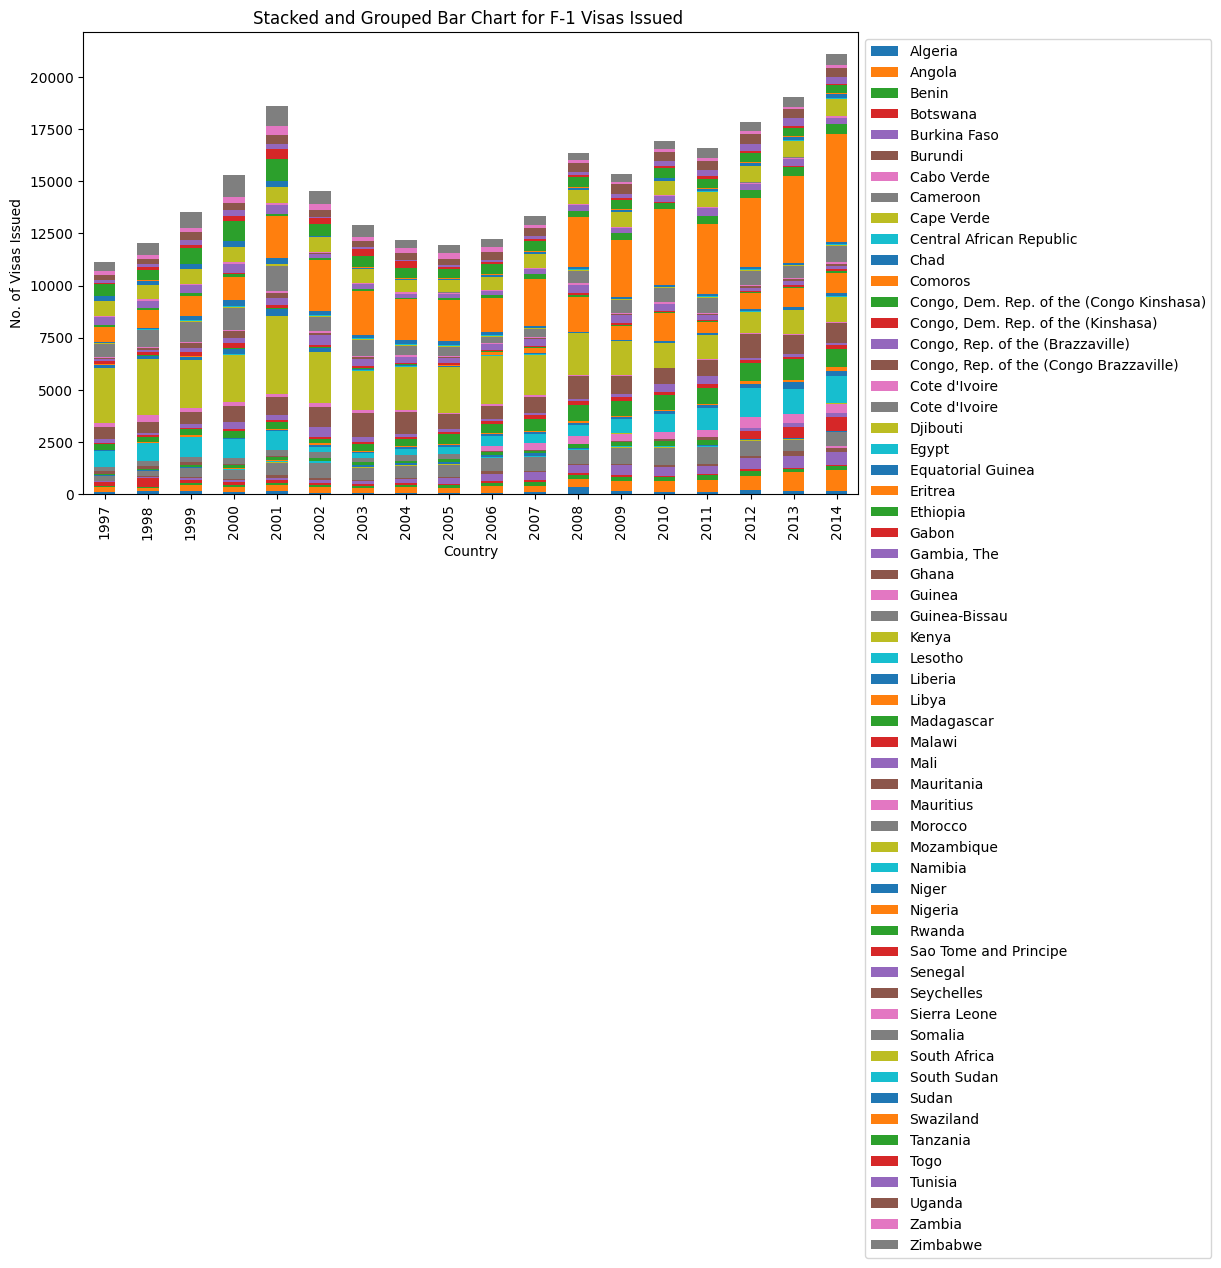

In [ ]:
data_visualization('Africa','F-1')

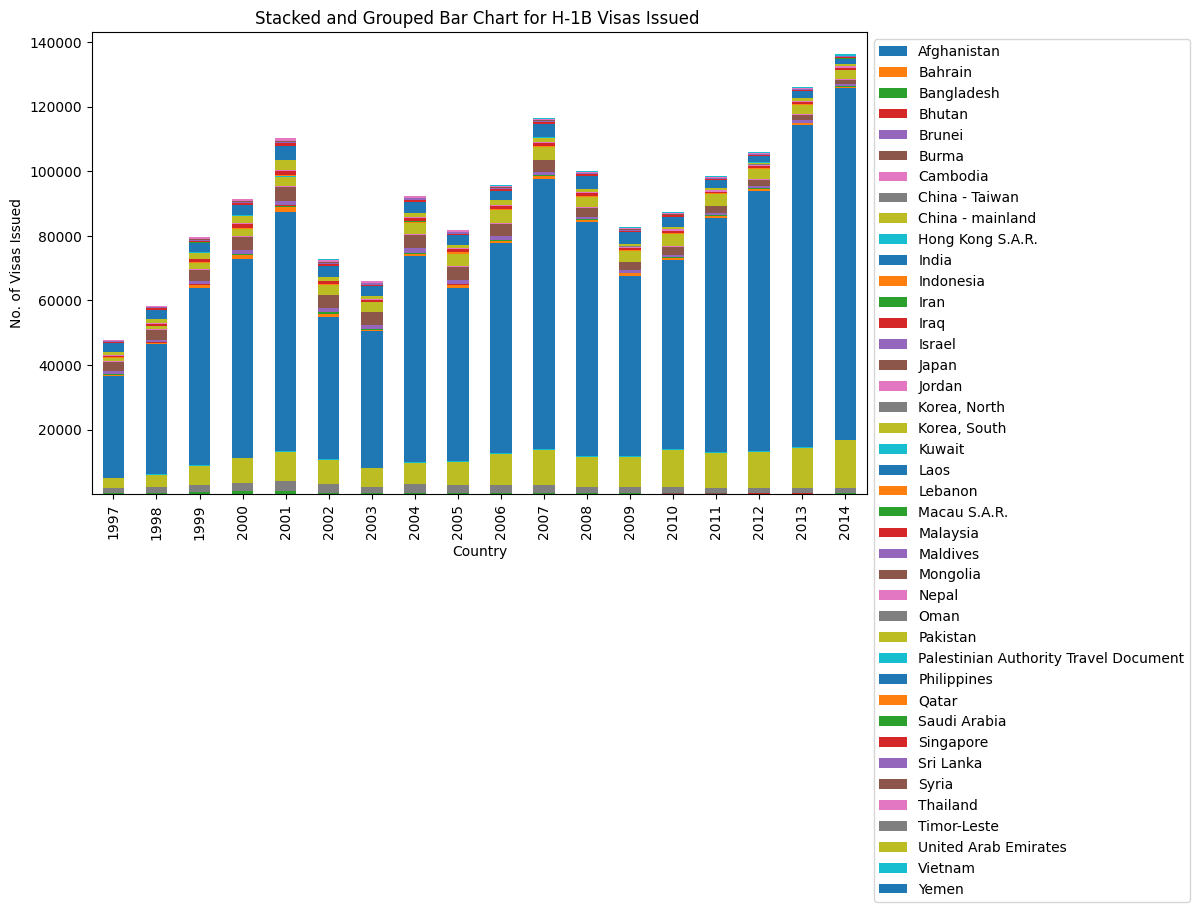

In [ ]:
data_visualization('Asia','H-1B')

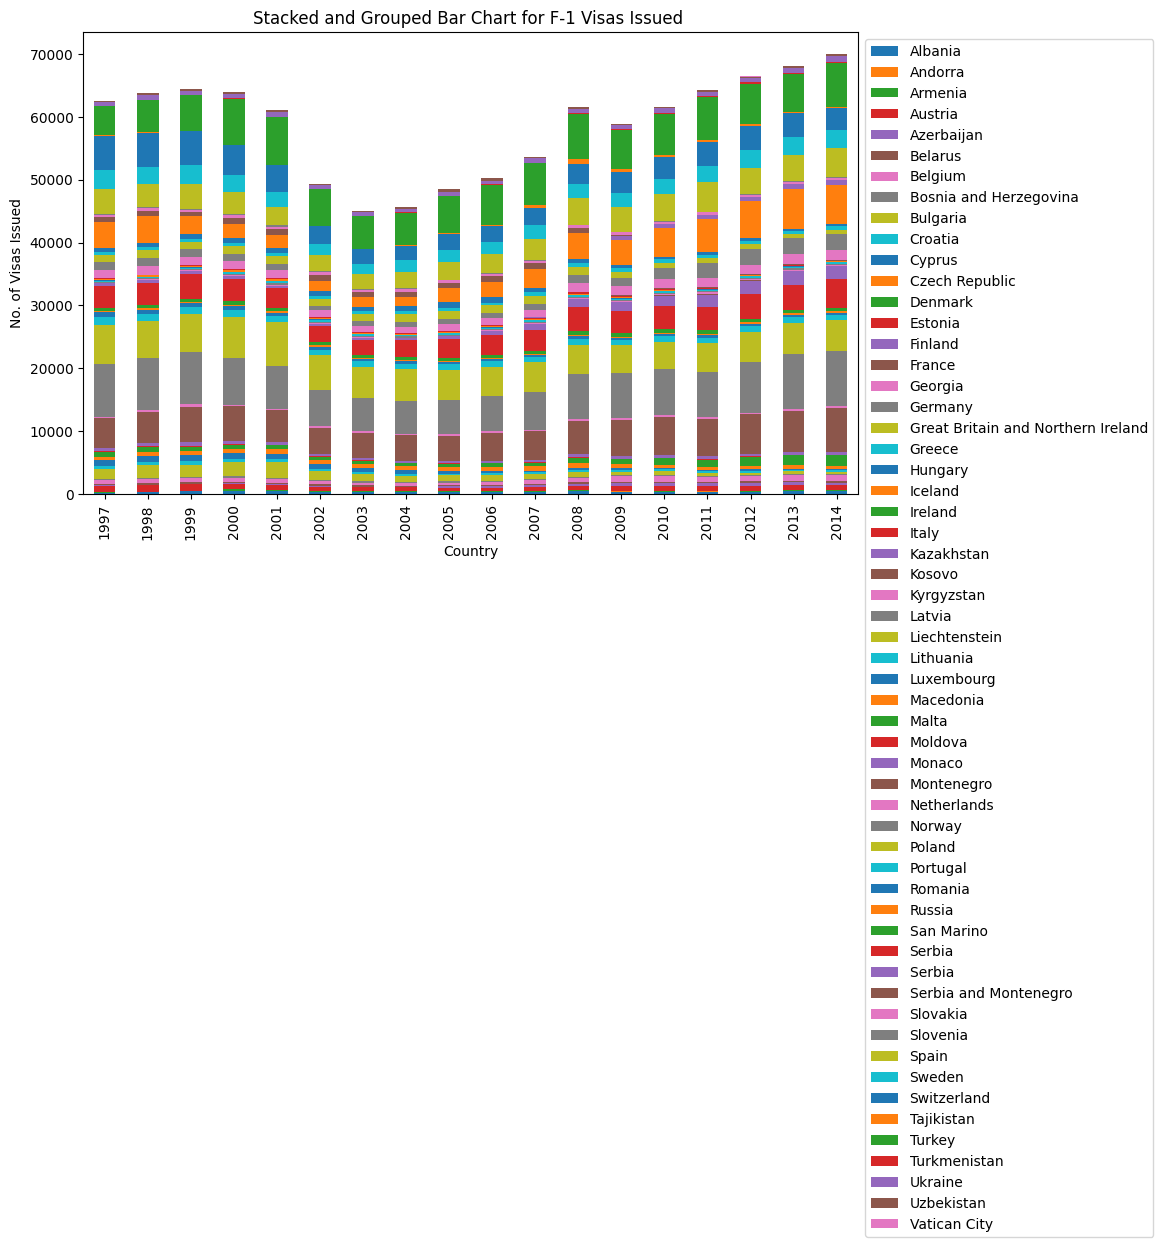

In [ ]:
data_visualization('Europe','F-1')

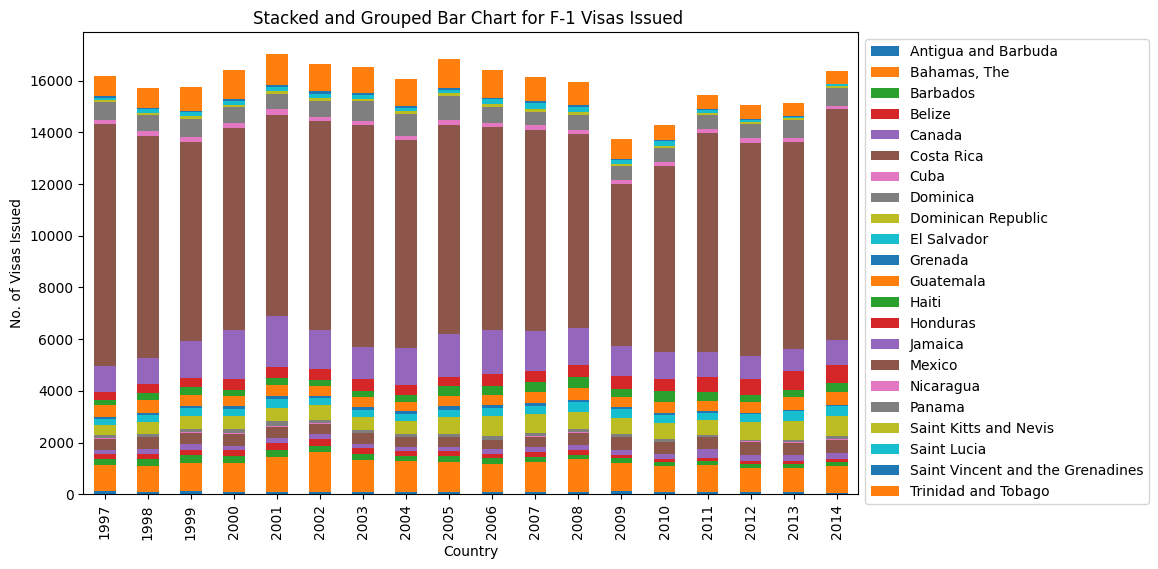

In [ ]:
data_visualization('North America','F-1')

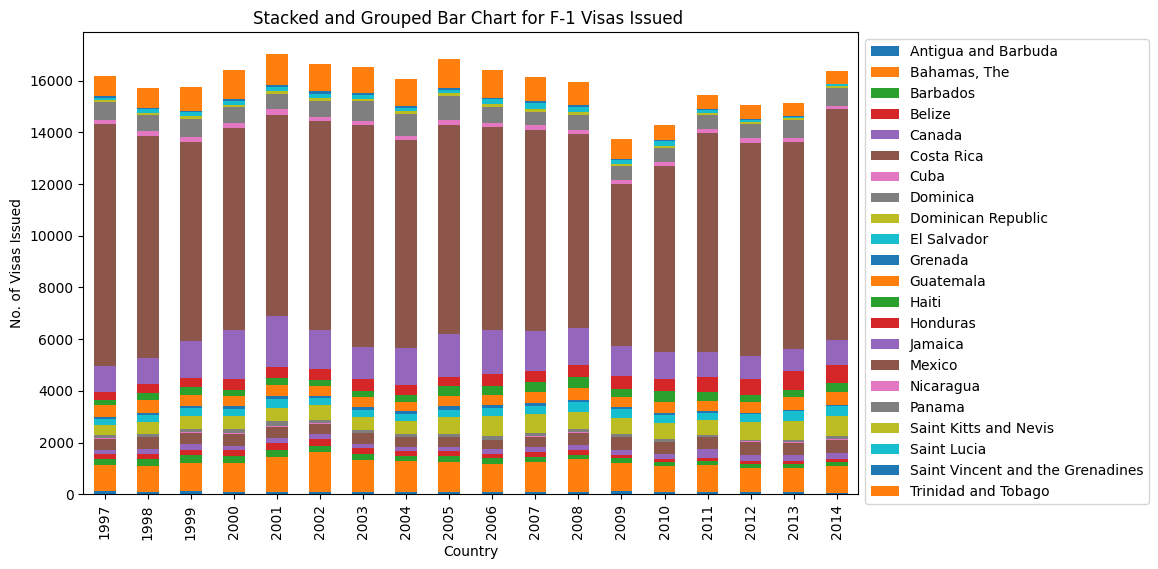

In [ ]:
data_visualization('North America','F-1')

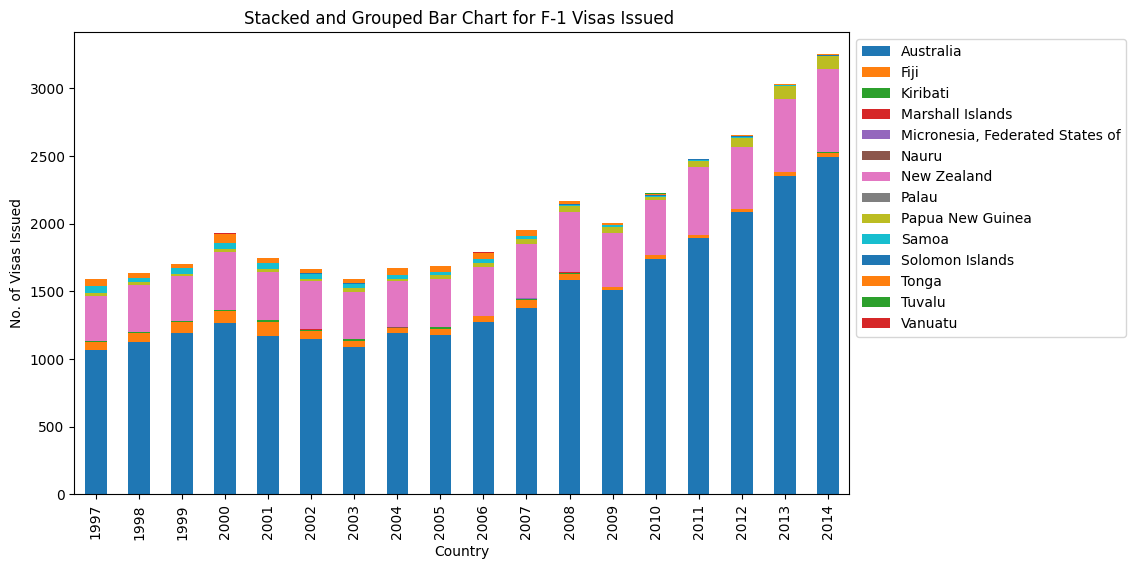

In [ ]:
data_visualization('Oceania','F-1')

Finding the statastics for every visa category

In [ ]:
df.describe()

,index,A-1,A-2,A-3,B-1,"B-1,2",B-2,"B-1,2/BCC","B-1,2/BCV",C-1,...,BCC,Fiscal_Year,D-CREW,H-1A,Q-2,Q-3,V-1,V-2,V-3,H-2R
count,3528.000000,3528.000000,3528.000000,3528.000000,3528.000000,3.528000e+03,3528.000000,3.528000e+03,3528.000000,3528.000000,...,3528.000000,3528.000000,3528.0,3528.000000,3528.000000,3528.000000,3528.000000,3528.000000,3528.000000,3528.000000
mean,101.886621,52.685091,417.852608,7.595805,377.298469,1.820930e+04,1901.928855,4.287022e+03,697.065760,167.067177,...,12.373016,2005.549036,0.0,0.023810,0.385771,0.002551,13.924603,15.748866,12.929989,34.528628
std,59.399702,80.432519,861.691139,28.248611,3161.293127,6.453815e+04,16483.237919,6.800695e+04,16440.810344,1242.579113,...,192.690202,5.187702,0.0,0.574972,7.843919,0.077120,224.596581,241.640484,352.312022,1092.473865
min,1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000e+00,-6.000000,0.000000e+00,0.000000,0.000000,...,0.000000,1997.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.750000,9.000000,31.000000,0.000000,6.000000,5.560000e+02,13.000000,0.000000e+00,0.000000,3.000000,...,0.000000,2001.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,102.500000,27.000000,129.000000,1.000000,43.000000,2.235000e+03,90.000000,0.000000e+00,0.000000,12.000000,...,0.000000,2006.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,152.000000,57.000000,359.250000,5.000000,190.250000,1.028075e+04,543.500000,0.000000e+00,0.000000,57.000000,...,0.000000,2010.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,209.000000,641.000000,8871.000000,492.000000,144278.000000,1.403617e+06,488675.000000,1.990402e+06,458902.000000,41824.000000,...,8260.000000,2014.000000,0.0,32.000000,221.000000,3.000000,8941.000000,8790.000000,15310.000000,51734.000000


Finding the statastics for each continent

In [ ]:
df.groupby('Continent').describe()

index                                                       \
               count        mean        std    min     25%    50%     75%   
Continent                                                                   
Africa         958.0   27.112735  15.372077    1.0   14.00   27.0   40.00   
Asia           732.0   76.064208  11.765956   56.0   66.00   76.0   86.00   
Europe         974.0  125.473306  15.703994   97.0  112.00  125.0  139.00   
North America  396.0  165.500000   6.660482  152.0  160.00  165.5  171.00   
Oceania        252.0  185.500000   4.508955  176.0  182.00  185.5  189.00   
South America  216.0  200.500000   3.998837  192.0  197.75  200.5  203.25   

                        A-1             ...  V-3            H-2R              \
                 max  count       mean  ...  75%      max  count        mean   
Continent                               ...                                    
Africa          54.0  958.0  34.372651  ...  0.0    108.0  958.0    0.498956   
Asia            97.0  732.0  81.658470  ...  0.0    674.0  732.0    0.133880   
Europe         155.0  974.0  48.926078  ...  0.0     69.0  974.0    2.701232   
North America  179.0  396.0  60.542929  ...  0.0  15310.0  396.0  296.005051   
Oceania        195.0  252.0  15.496032  ...  0.0      2.0  252.0    4.003968   
South America  209.0  216.0  81.648148  ...  0.0    132.0  216.0    1.773148   

                                                         
                       std  min  25%  50%  75%      max  
Continent                                                
Africa           13.523288  0.0  0.0  0.0  0.0    416.0  
Asia              2.050951  0.0  0.0  0.0  0.0     50.0  
Europe           34.810809  0.0  0.0  0.0  0.0    920.0  
North America  3251.997457  0.0  0.0  0.0  0.0  51734.0  
Oceania          31.635813  0.0  0.0  0.0  0.0    305.0  
South America    14.066269  0.0  0.0  0.0  0.0    146.0  

[6 rows x 752 columns]

Finding the statistics for the data which is collected above for plotting stacked chart 

In [ ]:
df['F-1'].describe()

count      3528.000000
mean       1688.225624
std        8436.722952
min           0.000000
25%          63.750000
50%         251.500000
75%         825.000000
max      244927.000000
Name: F-1, dtype: float64

In [ ]:
df.groupby('Continent').describe()

index                                                       \
               count        mean        std    min     25%    50%     75%   
Continent                                                                   
Africa         958.0   27.112735  15.372077    1.0   14.00   27.0   40.00   
Asia           732.0   76.064208  11.765956   56.0   66.00   76.0   86.00   
Europe         974.0  125.473306  15.703994   97.0  112.00  125.0  139.00   
North America  396.0  165.500000   6.660482  152.0  160.00  165.5  171.00   
Oceania        252.0  185.500000   4.508955  176.0  182.00  185.5  189.00   
South America  216.0  200.500000   3.998837  192.0  197.75  200.5  203.25   

                        A-1             ...  V-3            H-2R              \
                 max  count       mean  ...  75%      max  count        mean   
Continent                               ...                                    
Africa          54.0  958.0  34.372651  ...  0.0    108.0  958.0    0.498956   
Asia            97.0  732.0  81.658470  ...  0.0    674.0  732.0    0.133880   
Europe         155.0  974.0  48.926078  ...  0.0     69.0  974.0    2.701232   
North America  179.0  396.0  60.542929  ...  0.0  15310.0  396.0  296.005051   
Oceania        195.0  252.0  15.496032  ...  0.0      2.0  252.0    4.003968   
South America  209.0  216.0  81.648148  ...  0.0    132.0  216.0    1.773148   

                                                         
                       std  min  25%  50%  75%      max  
Continent                                                
Africa           13.523288  0.0  0.0  0.0  0.0    416.0  
Asia              2.050951  0.0  0.0  0.0  0.0     50.0  
Europe           34.810809  0.0  0.0  0.0  0.0    920.0  
North America  3251.997457  0.0  0.0  0.0  0.0  51734.0  
Oceania          31.635813  0.0  0.0  0.0  0.0    305.0  
South America    14.066269  0.0  0.0  0.0  0.0    146.0  

[6 rows x 752 columns]

Plotting Scatter chart for two visa types issued to each Continent for all the years identified

In [ ]:
visaTypes=[]
def comparisonVisas(continent, visaTypes):
  countries=[] 
  for i in range(len(years_hard)):
    countries.append(list(df[(df['Continent'] == continent) & (df['Fiscal_Year']==years_hard[i])]['Country'].unique()))
  c_a=[]
  for inner_list in countries:
    c_a.extend(inner_list)

  visas=[]
  for i in range(len(years_hard)):
    visas.append(list(df[(df['Continent'] == continent) & (df['Fiscal_Year']==years_hard[i])][visaTypes[0]]))

  v_a=[]
  for inner_list in visas:
    v_a.extend(inner_list)

  years =[]
  for i in range(len(years_hard)):
    for j in range(visas[i].__len__()):
      years.append(years_hard[i])

  visas_h=[]
  for i in range(len(years_hard)):
    visas_h.append(list(df[(df['Continent'] == continent) & (df['Fiscal_Year']==years_hard[i])][visaTypes[1]]))

  v_h=[]
  for inner_list in visas_h:
    v_h.extend(inner_list)
      

  data2 = {
      'Country': c_a,
      'Year': years,
      'Visa1': v_a,
      'Visa2': v_h
    }

  df_biplot = pd.DataFrame(data2)

  fig, ax = plt.subplots(figsize=(10, 6))

  x = df_biplot['Visa1']
  y = df_biplot['Visa2']

  fit = np.polyfit(x, y, deg=1)

  ax.set_title('Scatter chart for '+ visaTypes[0]+ ' and '+ visaTypes[1]+ ' (Bivariate analysis)')
  ax.set_xlabel(visaTypes[0])
  ax.set_ylabel(visaTypes[1])

  ax.scatter(x, y)

  ax.plot(x, fit[0] * x + fit[1], color='red') 

  plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

  print("The slope of the line is {} and the intercept is {}.".format(fit[0],fit[1]))
  #print(df_biplot.describe())
  #print(df_biplot.groupby('Country').describe())


The slope of the line is 0.18249425551765144 and the intercept is 1294.2597233168995.


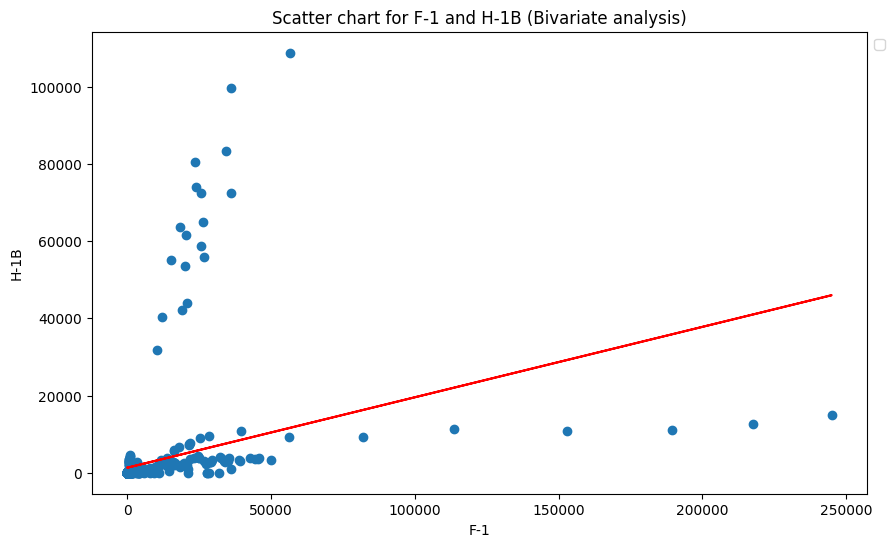

In [ ]:
comparisonVisas('Asia',['F-1','H-1B'])

The slope of the line is 2.8868766488608313 and the intercept is 183.92324708228998.


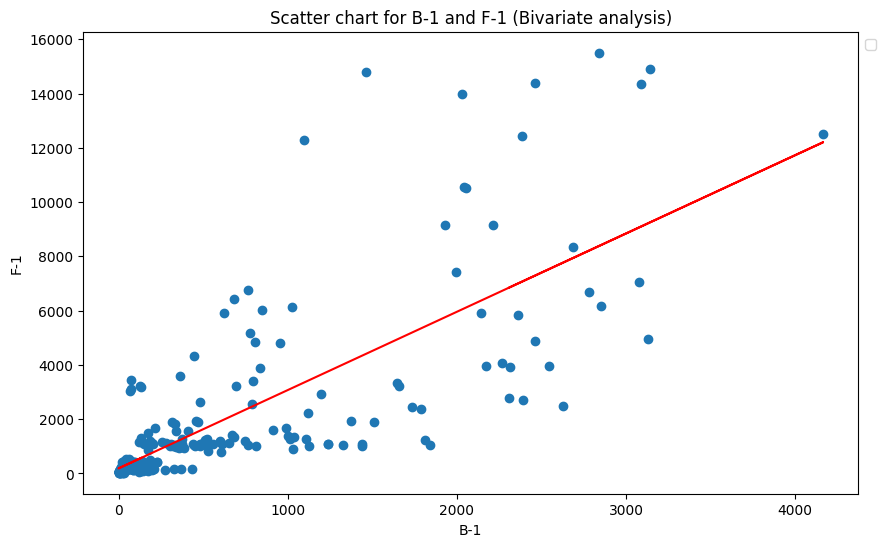

In [ ]:
comparisonVisas('South America',['B-1','F-1'])

The slope of the line is 0.0374160180944593 and the intercept is -7.926882487987955.


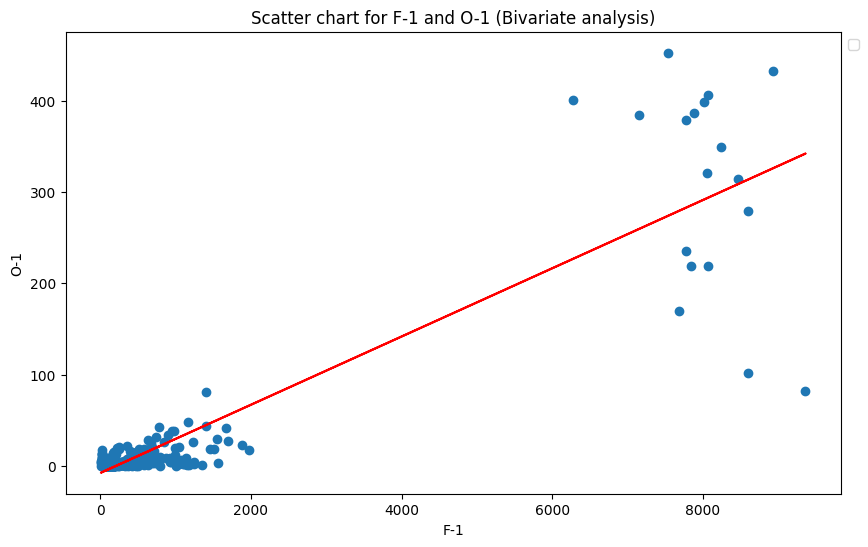

In [ ]:
comparisonVisas('North America',['F-1','O-1'])

Data Extraction of H-1B Petition Filing

In [ ]:
# Fetch the PDF data
url = 'https://www.uscis.gov/sites/default/files/document/data/h-1b-2007-2017-trend-tables.pdf'
response = requests.get(url)

# Open the PDF data with pdfplumber
with pdfplumber.open(BytesIO(response.content)) as pdf:
    table=pdf.pages[0].extract_table()
    df_country=pd.DataFrame(table[0::],columns=table[0])
    table2=pdf.pages[2].extract_table()
    df_Industry=pd.DataFrame(table2[0::],columns=table2[0])

In [ ]:
#Country Dataframe
df_country = df_country.iloc[:, :-4]
new_columns = df_country.iloc[2, :].tolist()
new_columns[0]='Country'
df_country.columns = new_columns
df_country = df_country.iloc[3:, :]
df_country = df_country.drop(df_country.index[-2])
df_country.reset_index(inplace=True)
df_country.drop(columns = ['index'],inplace=True)
df_country

,Country,2007,2008,2009,2010,2011,2012,2013,2014
0,India,"166,575","157,608","122,475","135,931","155,791","197,940","201,114","227,172"
1,"China, People's Republic of","26,370","24,434","22,411","21,119","23,227","22,528","23,924","27,733"
2,Philippines,"12,230","10,713","10,407","8,887","9,098","9,400","7,399","6,772"
3,South Korea,"10,730","10,277","10,704","8,721","7,480","7,204","5,576","4,897"
4,Canada,"8,562","7,111","7,871","7,342","6,761","6,688","5,478","5,267"
5,Taiwan,"5,394","4,088","4,308","4,325","4,511","4,172","3,520","3,267"
6,Mexico,"4,259","3,680","3,599","3,260","3,439","3,602","2,985","2,769"
7,United Kingdom,"5,105","4,241","4,270","3,651","3,241","3,130","2,330","1,988"
8,Pakistan,"4,259","3,803","3,683","3,012","3,033","2,765","2,381","2,497"
9,France,"4,112","3,687","3,035","2,660","2,531","2,292","2,192","2,024"


Converting continenets to the int64 in order to avoid any data releated issue while training model. While generating model there was an error because all data was not of same type.

In [ ]:
df = pd.read_csv('Data_All_Years.csv', index_col='Fiscal_Year')
df['Continent_new']=df['Continent']
df['Continent_new'] = df['Continent_new'].replace('Europe',1)
df['Continent_new'] = df['Continent_new'].replace('Africa',2)
df['Continent_new'] = df['Continent_new'].replace('Asia',3)
df['Continent_new'] = df['Continent_new'].replace('North America',4)
df['Continent_new'] = df['Continent_new'].replace('Oceania',5)
df['Continent_new'] = df['Continent_new'].replace('South America',6)
df.drop('Continent',axis=1,inplace = True)
df['Continent'] = df['Continent_new']
df.drop('Continent_new',axis=1,inplace = True)

Removing Unwanted data and adding all the required visa type of which we want to make a predictions.

In [ ]:

df["Approval_Count"] =  df["F-1"] + df["H-1B"] + df["B-1,2"] + df["O-1"] + df["B-1"] + df["B-2"]
relevant_cols = ["Fiscal_Year", "Approval_Count","Continent"]

for columns in df.columns:
  if columns not in relevant_cols:
    df.drop(columns,axis=1,inplace=True)

In [ ]:
df.tail()

,Continent,Approval_Count
Fiscal_Year,,
1997,6,6664.0
1997,6,50510.0
1997,6,2817.0
1997,6,21870.0
1997,6,78807.0


Combining all the unique continent data

In [ ]:
grouped_df = df.groupby([df.index,df['Continent']]).agg({'Approval_Count': 'sum', 'Continent': 'max'})

In [ ]:
df = grouped_df.droplevel(1)
df.head()

,Approval_Count,Continent
Fiscal_Year,,
1997,808263.0,1
1997,229317.0,2
1997,2062983.0,3
1997,503327.0,4
1997,25952.0,5


In [ ]:
df.index

Int64Index([1997, 1997, 1997, 1997, 1997, 1997, 1998, 1998, 1998, 1998,
            ...
            2013, 2013, 2013, 2013, 2014, 2014, 2014, 2014, 2014, 2014],
           dtype='int64', name='Fiscal_Year', length=108)

Using time series analysis, trying to predict the following years visa approval count. ARIMA is a popular model for predicting time series, especially when the time series properties change over time

Continent: 1


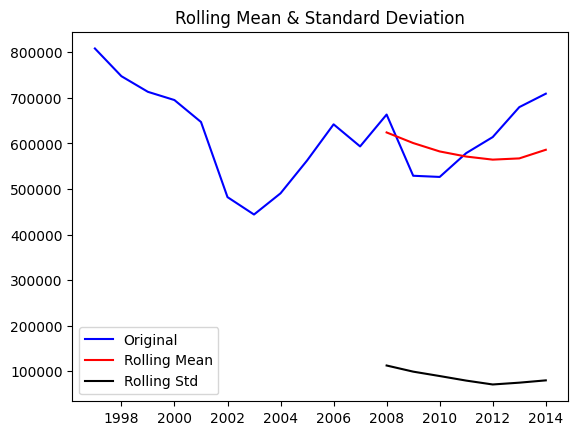

Continent: 2


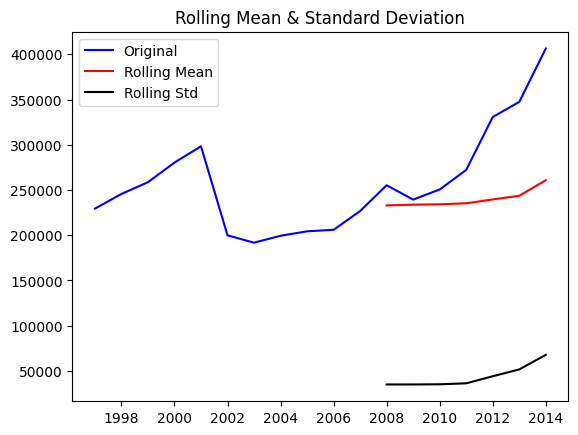

Continent: 3


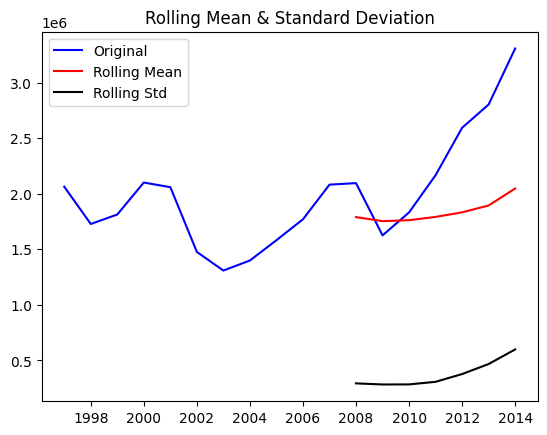

Continent: 4


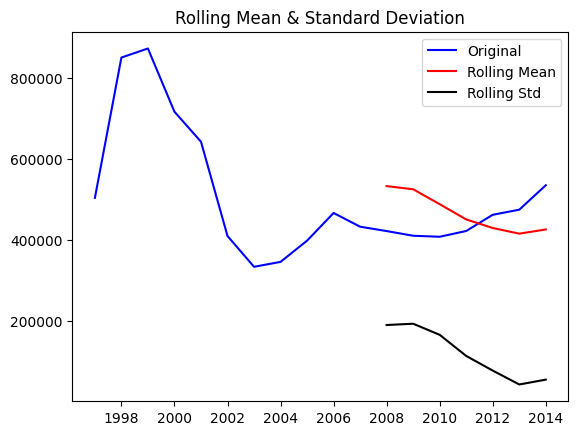

Continent: 5


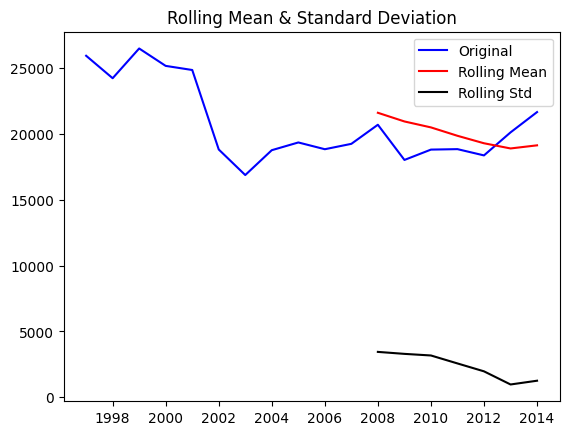

Continent: 6


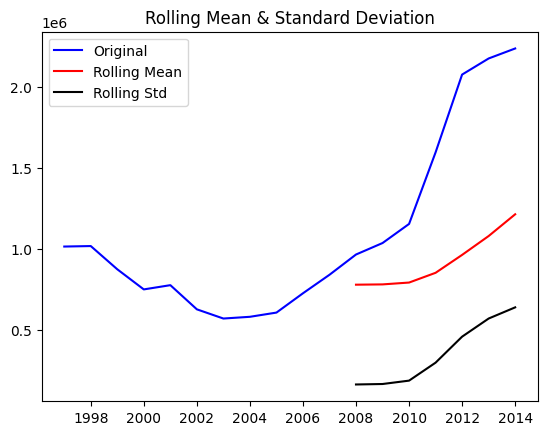

Continent: 1
Europe
Predictions for 2014 and 2015
2015-01-01    685236.356582
2016-01-01    682644.433931
Freq: AS-JAN, Name: predicted_mean, dtype: float64
Continent: 2
Africa
Predictions for 2014 and 2015
2015-01-01    415985.543973
2016-01-01    420483.102011
Freq: AS-JAN, Name: predicted_mean, dtype: float64
Continent: 3
Asia
Predictions for 2014 and 2015
2015-01-01    3.284636e+06
2016-01-01    3.284186e+06
Freq: AS-JAN, Name: predicted_mean, dtype: float64
Continent: 4
North America
Predictions for 2014 and 2015
2015-01-01    546630.370694
2016-01-01    517732.176760
Freq: AS-JAN, Name: predicted_mean, dtype: float64
Continent: 5
Oceania
Predictions for 2014 and 2015
2015-01-01    21107.229140
2016-01-01    20721.736492
Freq: AS-JAN, Name: predicted_mean, dtype: float64
Continent: 6
South America
Predictions for 2014 and 2015
2015-01-01    2.274986e+06
2016-01-01    2.300989e+06
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [ ]:
# Convert the year column to a datetime object
df.index = pd.to_datetime(df.index, format='%Y')


def check_Stationarity(timeseries):
    # Calculate rolling statistics
    mean = timeseries.rolling(window=12).mean()
    std = timeseries.rolling(window=12).std()

    # Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(mean, color='red', label='Rolling Mean')
    plt.plot(std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# Check for stationarity for each continent
for continent in df['Continent'].unique():
    print('Continent:', continent)
    check_Stationarity(df[df['Continent'] == continent]['Approval_Count'])

continents_names=['Europe','Africa','Asia','North America','Oceania','South America']

for continent in df['Continent'].unique():
    print('Continent:', continent)
    data = df[df['Continent'] == continent]['Approval_Count']
    train = data[:]
    warnings.filterwarnings("ignore")

    # Train the ARIMA model
    model = ARIMA(train, order=(2, 1, 2))
    fitted_model = model.fit()

    # Predicting model for 2 years
    predictions = fitted_model.predict(start=len(train), end=len(train) + 1, typ='levels')
    print(f'{continents_names[element]}\nPredictions for 2014 and 2015\n{predictions}')
    element+=1

Output :
The preceding graph depicts the trend of rolling mean and standard deviation for all continents over the specified time period.

Each continent's predictions for the forthcoming years [2014-2015] are listed above.

### Research Question 2 

In [ ]:
# Fetch the PDF data
url = 'https://www.uscis.gov/sites/default/files/document/data/h-1b-2007-2017-trend-tables.pdf'
response = requests.get(url)

# Open the PDF data with pdfplumber
with pdfplumber.open(BytesIO(response.content)) as pdf:
    table=pdf.pages[0].extract_table()
    df_country=pd.DataFrame(table[0::],columns=table[0])
#Country Dataframe
df_country = df_country.iloc[:, :-4]
new_columns = df_country.iloc[2, :].tolist()
new_columns[0]='Country'
df_country.columns = new_columns
df_country = df_country.iloc[3:, :]
df_country = df_country.drop(df_country.index[-2])
df_country.reset_index(inplace=True)
df_country.drop(columns = ['index'],inplace=True)
df_country = df_country.replace(',', '', regex=True)
country = ['2007',	'2008',	'2009',	'2010',	'2011',	'2012',	'2013',	'2014']
for i in country:
  df_country[i] = df_country[i].astype(int)
df_petition = df_country.sum(numeric_only=True, axis=0)
df_petition['Country'] = 'All Countries'
df_petition = df_country.append(df_petition, ignore_index=True)
df_petition = df_petition.iloc[-1:]
df_petition = df_petition.reset_index(drop=True)
df_petition=df_petition.transpose()
df_petition.columns = ["Count"]
df_petition.insert(0, "Fiscal_Year", df_petition.index)
df_petition=df_petition.reset_index(drop=True)
df_petition = df_petition.iloc[1:]
df_petition.reset_index(inplace=True)
df_petition.drop(columns = ['index'],inplace=True)
df_petition['gdp'] = gdp
df_petition['Count'] = pd.to_numeric(df_petition['Count'], errors='coerce')

In [ ]:
df = pd.concat([df_14,df_13,df_12,df_11,df_10,df_09,df_08,df_07], axis=0)
df.reset_index(inplace=True)
df.fillna(0,inplace=True)
df.to_csv('Data_All_Years_modified1.csv')
df_Approval = pd.read_csv('Data_All_Years_modified1.csv', index_col='Fiscal_Year')
df_Approval['Continent_new']=df_Approval['Continent']
df_Approval['Continent_new'] = df_Approval['Continent_new'].replace('Europe',1)
df_Approval['Continent_new'] = df_Approval['Continent_new'].replace('Africa',2)
df_Approval['Continent_new'] = df_Approval['Continent_new'].replace('Asia',3)
df_Approval['Continent_new'] = df_Approval['Continent_new'].replace('North America',4)
df_Approval['Continent_new'] = df_Approval['Continent_new'].replace('Oceania',5)
df_Approval['Continent_new'] = df_Approval['Continent_new'].replace('South America',6)
df_Approval.drop('Continent',axis=1,inplace = True)
df_Approval['Continent'] = df_Approval['Continent_new']
df_Approval.drop('Continent_new',axis=1,inplace = True)
df_Approval.reset_index(inplace=True)
df_Approval= df_Approval[['Fiscal_Year', 'H-1B']]
df_Approval = df_Approval[df_Approval['Fiscal_Year'].between(2007, 2014)].groupby('Fiscal_Year')['H-1B'].sum().reset_index()
df_Approval.columns = ['Fiscal_Year', 'Count']
df_Approval['Count'] = df_Approval['Count'].astype(int).map('{:d}'.format)
df_Approval['gdp'] = gdp
df_Approval['Count'] = pd.to_numeric(df_Approval['Count'], errors='coerce')

In [ ]:
X = df_Approval[['Fiscal_Year', 'gdp']]
y = df_Approval['Count']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating linear regression object
lr = LinearRegression()

# Training the model
lr.fit(X_train, y_train)

# Making predictions on the test set
y_pred_test = lr.predict(X_test)

# Predicting for 2015
y_pred_2015_approval = lr.predict([[2015, 18206.02]])
y_pred_2015_approval = int(y_pred_2015_approval[0])
new_row = {'Fiscal_Year': 2015, 'Count': y_pred_2015_approval, 'gdp': 18206.02}
# add the new row to df_approval
df_Approval = df_Approval.append(new_row, ignore_index=True)
df_Approval['Fiscal_Year'] = df_Approval['Fiscal_Year'].astype(int).map('{:d}'.format)
df_Approval['Count'] = df_Approval['Count'].astype(int).map('{:d}'.format)
# Printing the predicted value for 2015
print("Predicted Approval count for 2015:", y_pred_2015_approval)

X = df_petition[['Fiscal_Year', 'gdp']]
y = df_petition['Count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_test = lr.predict(X_test)
y_pred_2015_petition = lr.predict([[2015, 18206.02]])
y_pred_2015_petition = int(y_pred_2015_petition[0])
print("Predicted petition count for 2015:", y_pred_2015_petition)
new_row = {'Fiscal_Year': 2015, 'Count': y_pred_2015_petition, 'gdp': 18206.02}
# add the new row to df_approval
df_petition = df_petition.append(new_row, ignore_index=True)
df_petition['Fiscal_Year'] = df_petition['Fiscal_Year'].astype(int).map('{:d}'.format)
df_petition['Count'] = df_petition['Count'].astype(int).map('{:d}'.format)

Predicted Approval count for 2015: 172879
Predicted petition count for 2015: 355474


In [ ]:
df_Approval

,Fiscal_Year,Count,gdp
0,2007,154044,14474.23
1,2008,129456,14769.86
2,2009,110357,14478.06
3,2010,117389,15048.96
4,2011,129126,15599.73
5,2012,135515,16253.97
6,2013,153206,16843.19
7,2014,161358,17550.68
8,2015,172879,18206.02


In [ ]:
df_petition

,Fiscal_Year,Count,gdp
0,2007,314621,14474.23
1,2008,285475,14769.86
2,2009,246126,14478.06
3,2010,248272,15048.96
4,2011,268412,15599.73
5,2012,308242,16253.97
6,2013,299690,16843.19
7,2014,325971,17550.68
8,2015,355474,18206.02
